# Deep Learning (Fall 1401 - Dr. Beigy)

Name: Mohammad Bagher Soltani
</br>
Student Number: 98105813

# 0. Pre

## Introduction
The purpose of this notebook is to teach you some essentials about the Pytorch library. We will also implement our own dataloader, model, and trainer, so that after we train the model, it can distinguish between different cloths! The good news is, if you do this notebook carefully and appropriately, you will have a nice snippet-base to use later on. So let's start `shift+Enter`ing :)

## Requirements

In [84]:
!pip install -q numpy torch torchvision pillow tqdm

## Imports

In [85]:
from copy import deepcopy
from math import ceil

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

# 1. Data

## Dataset and Dataloader

### Dataset
We will use Fashion-MNIST dataset for our experiments in this notebook. It is a small dataset, so you will not need a GPU for your training.

In [86]:
# Making datasets
train_set = FashionMNIST(root='fashion-mnist', download=True, train=True)
test_set = FashionMNIST(root='fashion-mnist', download=True, train=False)

In [87]:
import matplotlib.pyplot as plt

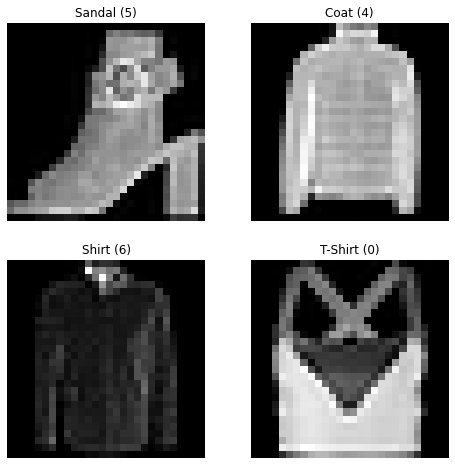

In [88]:
# Testing samples
######################   TODO 1.1   #########################
# Write a function to plot 4 random images from the 
# training set with their respective labels
###################### (5 points) #########################

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label] + " (" + str(label) + ")")
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

### Dataloader
Dataloader is an object that combines a dataset and a sampler, and provides an iterable over the given dataset. Pytorch has its own dataloader, but here, to understand what lies under the hood, we will implement our custom one.

In [89]:
class CustomDataloader:
    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        # images passed to the dataloader are PIL objests.
        # we need to convert those to tensors:
        self.transform = transforms.Compose([
            transforms.PILToTensor()
        ])
        
    def __len__(self):
        ######################   TODO 1.2   ########################
        # return the count of batches.
        return len(self.dataset) // self.batch_size
        ###################### (1 points) #########################

    def __iter__(self, calm=True):
        indexes = list(range(len(self.dataset)))

        for idx in range(0, len(self.dataset), self.batch_size):
            ######################   TODO 1.3   ########################
            # construct a batch of images respective to the indexes:
            # 1. construct a list of images
            # 2. convert the list to tensors
            # 3. convert tensors to float32 (each tensor element should be between 0 and 1)
            # 4. construct the respective labels list
            batch_indexes = indexes[idx: idx + self.batch_size]
            batch_imgs = [self.dataset[i][0] for i in batch_indexes]
            batch_imgs_transformed = torch.stack([self.transform(img) for img in batch_imgs]).float()
            batch_labels = [self.dataset[i][1] for i in batch_indexes]
            ###################### (8 points) #########################
            yield batch_imgs_transformed, torch.tensor(batch_labels)
        return


In [90]:
def test_dataloader():
    ######################   TODO 1.3   ########################
    # test your dataloader! 
    batch_size = 32
    dataloader = CustomDataloader(train_set, batch_size, shuffle=True)
    for data, labels in dataloader:
        assert data.shape == (batch_size, 1, 28, 28)
        assert labels.shape == (batch_size,)
        assert data.dtype == torch.float32
        assert labels.dtype == torch.int64
    ###################### (5 points) #########################

test_dataloader()

In [91]:
######################   TODO 1.4   #########################
# initialaze the dataloaders, for training_set and test_set
batch_size = 32
train_dataloader = CustomDataloader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = CustomDataloader(test_set, batch_size=batch_size, shuffle=True)
###################### (1 points) #########################

# 2. Model
Here, we will implement our network. Our model is a simple feed-forward network that gets an image, flattens the image, then passes it through several linear layers with relu activations.

In [92]:
dev = ""
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev)

In [93]:
class Classifier(nn.Module):
    def __init__(self, input_dims, hidden_dims, num_classes):
        super().__init__()
        self.nn_layers = nn.ModuleList()
        self.activation = nn.ReLU()
        self.flatten = torch.flatten
        ######################   TODO 2.1   ########################
        # construct layers of the network
        # these layers are stored in `self.nn_layers`
        # use `nn.Linear` for all layers
        dims = [input_dims[0] * input_dims[1]] + hidden_dims + [num_classes]
        for i in range(1, len(dims)):
          self.nn_layers.append(nn.Linear(dims[i - 1], dims[i]))
        # use `self.nn_layers.append`
        ###################### (10 points) #########################
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x, start_dim=1)
        ######################   TODO 2.2   ########################
        # pass `x` through all the layers of the network.
        # also don't forget the activation functions!
        # don't use `softmax` in the last layer.
        for layer in self.nn_layers:
          x = self.activation(layer(x))
        ###################### (5 points) #########################
        return x

    def predict(self, x):
        ######################   TODO 2.3   ########################
        # get the predicted class of x.
        # use softmax and then get the maximum indexes
        prediction = torch.argmax(self.softmax(self(x)), dim=1)
        ###################### (5 points) #########################
        return prediction


In [94]:
def test_model():
    input_dims = (28, 28)
    hidden_dims = [10, 100, 20]
    num_classes = 10
    batch_size = 8
    
    cls = Classifier(input_dims, hidden_dims, num_classes)
    x = torch.rand(batch_size, *input_dims)
    assert cls(x).shape == torch.Size([batch_size, num_classes])
    assert cls.predict(x).shape == torch.Size([batch_size])


def test_model_with_dataloader():
    input_dims = (28, 28)
    hidden_dims = [10, 100, 20]
    num_classes = 10
    batch_size = 8
    dataloader = CustomDataloader(dataset=test_set, batch_size=batch_size, shuffle=True)
    imgs, labels = next(iter(dataloader))
    cls = Classifier(input_dims, hidden_dims, num_classes)
    assert cls(imgs).shape == torch.Size([batch_size, num_classes])
    assert cls.predict(imgs).shape == torch.Size([batch_size])

test_model()
test_model_with_dataloader()

# 3. Training

## Trainer
Trainer is an object that gets the model, dataloaders, optimizer and criterion and then trains the model with the given data in a training loop. 

In [95]:
class Trainer:
    def __init__(self, 
        train_dataloader, val_dataloader, model,
        optimizer, criterion, *args, **kwargs
    ):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = model
        self.best_model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_losses = []
        self.val_losses = []
        self.val_loss = None
        self.min_val_loss = np.inf

    def train(self, epochs, log_each_n_percent_epoch):
        train_steps = len(self.train_dataloader)
        log_steps = int(train_steps * log_each_n_percent_epoch/100)

        for epoch in range(epochs):
            print(f"epoch {epoch+1} started".title().center(50, "="))
            train_loss = 0.0
            for step, (data, labels) in tqdm(enumerate(self.train_dataloader)):
                ######################   TODO 3.1   ########################
                # first move the data and labels to gpu if you are using it
                # forward the data, calculate loss and then backpropagate it
                ###################### (10 points) #########################
                self.optimizer.zero_grad()
                labels, data = labels.to(device), data.to(device)
                y_true, output = labels, self.model(data)
                loss = self.criterion(output, y_true)
                loss.backward()
                self.optimizer.step()

                if step % log_steps == 1:
                    self.val_loss, accuracy = self.evaluate(save=True)
                    info_text = f'Validation Loss: {self.val_loss:.6f}\t Accuracy-score: {accuracy:.2f}'
                    print(info_text)
                    self.post_evaluation_actions()
                    self.train_losses.append(loss)
                    
    def evaluate(self, save=False):
        with torch.no_grad():
            ######################   TODO 3.2   ########################
            # run the prediction on the validation dataloader,
            # calculate loss and accuracy
            data, labels = None, None
            for x, y in self.val_dataloader:
              data = x
              labels = y
            data, labels = data.to(device), labels.to(device)
            y_true, output = labels, self.model(data)
            val_loss = self.criterion(output, y_true)
            total = labels.size(0)
            y_pred = torch.argmax(self.model.softmax(output), dim=1)
            correct = (y_pred == y_true).sum().item()
            accuracy = correct / total

            if save and val_loss < self.min_val_loss:
              self.min_val_loss = val_loss
              self.best_model = self.model
            ###################### (5 points) #########################
            self.val_losses.append(val_loss)
            self.val_loss = val_loss
            return val_loss, accuracy

    def post_evaluation_actions(self):
        pass

## Train

In [96]:
from torch.optim import SGD, Adam, Adagrad
from torch.nn import CrossEntropyLoss

In [97]:
######################   TODO 3.3   #########################
# complete empty variables 
# init your model, then put it on GPU if available,
# use `SGD` as your optimizer,
# set the appropriate `learning_rate`
# use `nn.CrossEntropyLoss()` as criterion.
input_dims = (28, 28)
hidden_dims = [400, 300, 200, 150,  100, 60, 40, 30 , 20]
num_classes = 10

model = Classifier(input_dims, hidden_dims, num_classes)
model = model.to(device)

learning_rate = 0.01
optimizer = SGD(model.parameters(), learning_rate)
criterion = CrossEntropyLoss()
###################### (5 points) #########################

In [98]:
from torch.utils.data import random_split

In [99]:
######################   TODO 3.4   #######################
# init trainer and then train it as much as you want.
# accuracy scores less than 86% won't recieve any points.
epochs = 20
log_each_n_percent_epoch = 50
batch_size = 100
k = 10

split_lengths = [len(train_set) - len(train_set) // k , len(train_set) // k]
new_train_set, val_set = random_split(train_set, split_lengths, torch.Generator().manual_seed(12))
new_train_dataloader = CustomDataloader(new_train_set, batch_size)
val_dataloader = CustomDataloader(val_set, len(val_set))
trainer = Trainer(new_train_dataloader, val_dataloader, model, optimizer, criterion)
trainer.train(epochs, log_each_n_percent_epoch)
###################### (5 points) #########################

=================Epoch 1 Started==================


0it [00:00, ?it/s]

Validation Loss: 2.307525	 Accuracy-score: 0.10
Validation Loss: 2.192997	 Accuracy-score: 0.19
=================Epoch 2 Started==================


0it [00:00, ?it/s]

Validation Loss: 1.178422	 Accuracy-score: 0.50
Validation Loss: 0.817678	 Accuracy-score: 0.68
=================Epoch 3 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.631089	 Accuracy-score: 0.77
Validation Loss: 0.558733	 Accuracy-score: 0.80
=================Epoch 4 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.499689	 Accuracy-score: 0.83
Validation Loss: 0.495065	 Accuracy-score: 0.82
=================Epoch 5 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.466540	 Accuracy-score: 0.84
Validation Loss: 0.446378	 Accuracy-score: 0.84
=================Epoch 6 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.433894	 Accuracy-score: 0.85
Validation Loss: 0.422197	 Accuracy-score: 0.85
=================Epoch 7 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.417619	 Accuracy-score: 0.86
Validation Loss: 0.388886	 Accuracy-score: 0.87
=================Epoch 8 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.397340	 Accuracy-score: 0.86
Validation Loss: 0.369816	 Accuracy-score: 0.87
=================Epoch 9 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.383181	 Accuracy-score: 0.87
Validation Loss: 0.356618	 Accuracy-score: 0.87
=================Epoch 10 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.384808	 Accuracy-score: 0.87
Validation Loss: 0.351315	 Accuracy-score: 0.88
=================Epoch 11 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.362961	 Accuracy-score: 0.88
Validation Loss: 0.343418	 Accuracy-score: 0.88
=================Epoch 12 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.357116	 Accuracy-score: 0.88
Validation Loss: 0.342671	 Accuracy-score: 0.88
=================Epoch 13 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.358815	 Accuracy-score: 0.88
Validation Loss: 0.351371	 Accuracy-score: 0.88
=================Epoch 14 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.350900	 Accuracy-score: 0.88
Validation Loss: 0.345687	 Accuracy-score: 0.88
=================Epoch 15 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.346796	 Accuracy-score: 0.88
Validation Loss: 0.344057	 Accuracy-score: 0.88
=================Epoch 16 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.351631	 Accuracy-score: 0.88
Validation Loss: 0.361187	 Accuracy-score: 0.88
=================Epoch 17 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.367239	 Accuracy-score: 0.88
Validation Loss: 0.341348	 Accuracy-score: 0.89
=================Epoch 18 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.350589	 Accuracy-score: 0.89
Validation Loss: 0.339797	 Accuracy-score: 0.89
=================Epoch 19 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.359069	 Accuracy-score: 0.88
Validation Loss: 0.372113	 Accuracy-score: 0.88
=================Epoch 20 Started=================


0it [00:00, ?it/s]

Validation Loss: 0.363571	 Accuracy-score: 0.89
Validation Loss: 0.349161	 Accuracy-score: 0.89


In [100]:
######################   TODO 3.5   #######################
# repeat the training with another optimizer.
###################### (5 points) #########################
model2 = Classifier(input_dims, hidden_dims, num_classes)
model2 = model2.to(device)
learning_rate2 = 0.01
optimizer2 = torch.optim.RMSprop(model2.parameters(), lr=learning_rate2)
criterion2 = CrossEntropyLoss()

new_train_dataloader2 = CustomDataloader(new_train_set, batch_size)
val_dataloader2 = CustomDataloader(val_set, len(val_set))
trainer2 = Trainer(new_train_dataloader2, val_dataloader2, model2, optimizer2, criterion2)
trainer2.train(epochs, log_each_n_percent_epoch=50)

=================Epoch 1 Started==================


0it [00:00, ?it/s]

Validation Loss: 6981.525879	 Accuracy-score: 0.10
Validation Loss: 2.303172	 Accuracy-score: 0.10
=================Epoch 2 Started==================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 3 Started==================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 4 Started==================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 5 Started==================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 6 Started==================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 7 Started==================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 8 Started==================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 9 Started==================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 10 Started=================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 11 Started=================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 12 Started=================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 13 Started=================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 14 Started=================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 15 Started=================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 16 Started=================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 17 Started=================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 18 Started=================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 19 Started=================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10
=================Epoch 20 Started=================


0it [00:00, ?it/s]

Validation Loss: 2.302583	 Accuracy-score: 0.10
Validation Loss: 2.302583	 Accuracy-score: 0.10


## Trainer with Early Stopping
First, feel free to study about Early Stopping technique on the internet. Then come along to the next cell.

In [101]:
class EarlyStppedException(Exception):
    pass


class TrainerWithEarlyStopping(Trainer):
    def  __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        ######################   TODO 3.6   #######################
        # Here, save any arguments you need from kwargs into `self`
        # arguments for early stopping
        self.patience = kwargs['patience']
        self.min_delta = kwargs['min_delta']
        self.epochs_without_improvement = 0
        ###################### (3 points) #########################

    def post_evaluation_actions(self):
        ######################   TODO 3.6   #######################
        # In this method, you should first save the best model each
        # time the loss decreases. Don't forget to use `deepcopy`!
        # Then use your defined arguments to check for early stopp-
        # ing. In case of eary stopping raise `EarlyStppedException`
        # exception.
        if self.val_loss < self.min_val_loss:
            # save best model
            self.best_model = deepcopy(self.model)
            self.min_val_loss = self.val_loss
            self.epochs_without_improvement = 0
        else:
            # min delta is the minimum change in loss
            if self.val_loss - self.min_val_loss > self.min_delta:
                self.epochs_without_improvement += 1
                if self.epochs_without_improvement > self.patience:
                    raise EarlyStppedException
        ###################### (7 points) #########################

In [102]:
######################   TODO 3.6   #######################
# Train a new model using our new trainer.
# to claim the earlystopping point you should also do this
# section.
model3 = Classifier(input_dims, hidden_dims, num_classes)
model3.to(device)

optimizer3 = torch.optim.SGD(model3.parameters(), lr=learning_rate)
criterion3 = CrossEntropyLoss()

new_train_dataloader3 = CustomDataloader(new_train_set, batch_size)
val_dataloader3 = CustomDataloader(val_set, len(val_set))
trainer3 = TrainerWithEarlyStopping(new_train_dataloader3, val_dataloader3, model3, optimizer3, criterion3, patience=3, min_delta=5e-4)
trainer3.train(epochs, log_each_n_percent_epoch)
###################### ( 0 points) #########################

=================Epoch 1 Started==================


0it [00:00, ?it/s]

Validation Loss: 2.305348	 Accuracy-score: 0.09
Validation Loss: 1.906760	 Accuracy-score: 0.22
=================Epoch 2 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.880574	 Accuracy-score: 0.61
Validation Loss: 0.888847	 Accuracy-score: 0.66
=================Epoch 3 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.585725	 Accuracy-score: 0.79
Validation Loss: 0.530822	 Accuracy-score: 0.81
=================Epoch 4 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.487493	 Accuracy-score: 0.83
Validation Loss: 0.510197	 Accuracy-score: 0.82
=================Epoch 5 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.465021	 Accuracy-score: 0.83
Validation Loss: 0.490113	 Accuracy-score: 0.83
=================Epoch 6 Started==================


0it [00:00, ?it/s]

Validation Loss: 0.423339	 Accuracy-score: 0.85
Validation Loss: 0.473364	 Accuracy-score: 0.84


EarlyStppedException: ignored

# 4. Plots

**4.1. plot the learning curves for both optimizers.(5 points)**

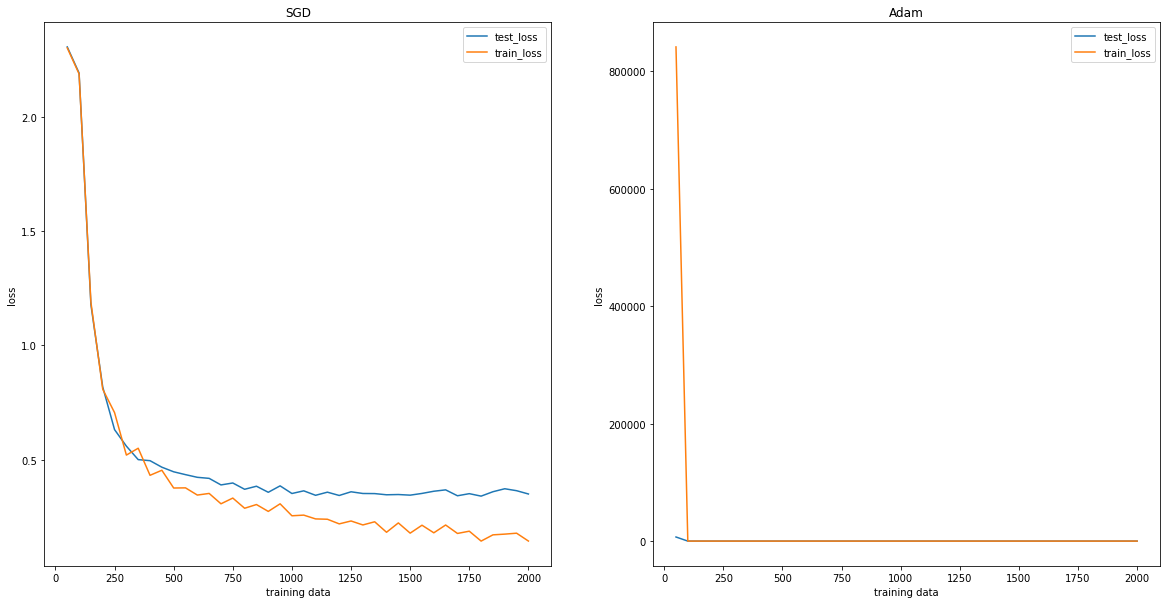

In [103]:
def plot_data():
  fig, axs = plt.subplots(1, 2)
  fig.set_figheight(10)
  fig.set_figwidth(20)
  sgd_losses = [[t.item() for t in trainer.val_losses], [t.item() for t in trainer.train_losses]]
  adam_losses = [[t.item() for t in trainer2.val_losses], [t.item() for t in trainer2.train_losses]]
  total_iterations = int(epochs / (log_each_n_percent_epoch / 100))
  data_per_iteration = int(batch_size * (log_each_n_percent_epoch / 100))
  X = np.arange(data_per_iteration, (total_iterations + 1) * data_per_iteration, data_per_iteration)
  axs[0].plot(X, sgd_losses[0], label="test_loss")
  axs[0].plot(X, sgd_losses[1], label="train_loss")
  axs[0].set(xlabel="training data", ylabel="loss", )
  axs[0].title.set_text("SGD")
  axs[0].legend(loc="upper right")
  axs[1].plot(X, adam_losses[0], label="test_loss")
  axs[1].plot(X, adam_losses[1], label="train_loss")
  axs[1].set(xlabel="training data", ylabel="loss")
  axs[1].legend(loc="upper right")
  axs[1].title.set_text("Adam")
  plt.show()

plot_data()

**4.2. plot the confusion matrix on the test set (5 points)**

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

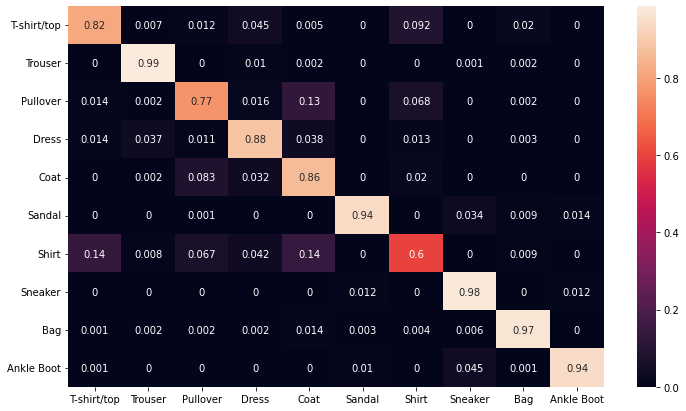

In [106]:
y_pred = []
y_true = []

net = trainer.best_model
# iterate over test data
for data, labels in test_dataloader:
  data, labels = data.to(device), labels.to(device)
  output = net(data) # Feed Network

  output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
  y_pred.extend(output) # Save Prediction
  
  labels = labels.data.cpu().numpy()
  y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

# 5. Conclusion

**5.1. what does `torch.no_grad()` do? (5 points)** [link text](https://)

It is used when we don't need to update weights using .backward() on loss. This is typically the case for validation and testing, because we don't want to train the data, but only predict the outputs and caluclate some loss without computing gradient. Using with torch.no_grad() prevents from computing gradient and reduces the computational overhead from computing the gradient.


**5.2. what is the diference between `CrossEntropyLoss` and `NLLLOSS`? Could we use `NLLLOSS` instead? How? (5 points)**

CrossEntropyLoss is just like NLLLOss with the difference being that it expects weights of each class instead of log-probabilities of the weights for the output.
Therefore, YES, we can use NLLLOSS IF we add a LogSoftMax layer to in the last layer in the neural network